In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# CNN - extract features

Pre-process image

In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import math
import cv2
import pydicom
import os
from tqdm import tqdm
import glob
import pickle as pkl
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno
from IPython.display import display_html
from PIL import Image
import gc
from skimage.transform import resize
import copy
import re
from scipy.stats import pearsonr

# Segmentation
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

#------------------------------------------------------------

pd.set_option("display.max_columns", 100)

#Define resolution of image 512*512
N_ROWS = 512
N_COLS = 512
path = 'C:/Users/frank/OneDrive/Desktop/Thesis - Progress Prediction/CodeDevelopment/osic-pulmonary-fibrosis-progression/'
#Define Batch size
BATCH_SIZE=128

# Areas with the same number of pixels on the edges are not required. Crop it.
def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]

# Load images, crop thick borders(if any) and resize
def load_image(path):
    dataset = pydicom.dcmread(path)
    img = dataset.pixel_array
    img = crop_image(img)
#   img = cv2.resize(img, (512,512))
    return img

# Get Nth percentile image
def get_img(perc, patient_id, data):

    l = glob.glob(path+'{0}/{1}/*.dcm'.format(data, patient_id))
    img_ids = []
    for x in l:
        y = x.split('\\')[-1]
        z = int(y.split('.')[0])
        img_ids.append(z)

    img_ids.sort()

    return img_ids[math.ceil(perc*(len(img_ids)))-1]

# Get num of slices bw two percentiles
def num_img_bw_perc(p1, p2, patient_id, data):

    l = glob.glob(path+'{0}/{1}/*.dcm'.format(data, patient_id))
    img_ids = []
    for x in l:
        y = x.split('\\')[-1]
        z = int(y.split('.')[0])
        img_ids.append(z)

    img_ids.sort()

    return len(img_ids[math.ceil(p1*(len(img_ids)))-1:math.ceil(p2*(len(img_ids)))])-1


# Get number of images per patient
def get_num_images(patient_id, data):

    return len(glob.glob(path+'{0}/{1}/*.dcm'.format(data, patient_id)))

# Get the lung area in the image slice
def lung_seg_pixel_ratio(img_array):

    c = 0
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            if img_array[i][j] != 0:
                c+=1

    return c, round(c/(img_array.shape[0]*img_array.shape[1]),4)

# Get dicom meta data
def get_dicom_meta(path):

    '''Get information from the .dcm files.
    path: complete path to the .dcm file'''

    image_data = pydicom.dcmread(path)

    # Dictionary to store the information from the image
    observation_data = {
        "SliceThickness" : float(image_data.SliceThickness),
        "PixelSpacing" : float(image_data.PixelSpacing[0]),
    }

    return observation_data

# Get tissue mask
# To extract the tissues from the segmented lung all we need to do is get rid of the border parts from the segmented lung
# Grey pixels present within the border of the lung is assumed to be tissue.
# Inorder to get rid of the border pixels of the lung we slightly perturb the segmented lung to the right, left, top and bottom
# The intersection of all the perturbed images gets rid of the border lung pixels
# This resultant image serves as the mask for the tissue segmentation
def tissue_mask(img, mask, shift_perc):

    r_dim, c_dim = img.shape[0], img.shape[1]

    # Move the image by shift_perc to the left
    del_left_cols = int(shift_perc*c_dim)

    mask1, mask2 = mask.copy(), np.zeros((r_dim, c_dim)).astype(int)
    mask1 = mask1[:,del_left_cols:]
    mask2[:,:c_dim-del_left_cols] = mask1

    # Move the image by shift_perc to the right
    del_right_cols = int(shift_perc*c_dim)

    mask3, mask4 = mask.copy(), np.zeros((r_dim, c_dim)).astype(int)
    mask3 = mask3[:,:c_dim-del_right_cols]
    mask4[:,del_right_cols:] = mask3

    # Move the image by shift_perc to the top
    del_top_rows = int(shift_perc*c_dim) #BUG C_DIM SHOULD BE R_DIM

    mask5, mask6 = mask.copy(), np.zeros((r_dim, c_dim)).astype(int)
    mask5 = mask5[del_top_rows:,:]
    mask6[:r_dim-del_top_rows,:] = mask5

    # Move the image by shift_perc to the bottom
    del_bottom_rows = int(shift_perc*r_dim)

    mask7, mask8 = mask.copy(), np.zeros((r_dim, c_dim)).astype(int)
    mask7 = mask7[:r_dim-del_bottom_rows,:]
    mask8[del_bottom_rows:,:] = mask7

    #Obtain the final mask
    final_mask = ((mask2==1) & (mask4==1) & (mask6==1) & (mask8==1)).astype(int)

    return final_mask

# Get tissue features
def tissue_features(tissue_mask, img, thresh = 0.35):

    final_img = tissue_mask*img

    checker = np.zeros((final_img.shape[0], final_img.shape[1]))
    counter, other_counter = 0, 0
    for i in range(final_img.shape[0]):
        for j in range(final_img.shape[1]):
            if final_img[i][j]>=thresh:
                checker[i][j] = 1
                counter+=1
            else:
                checker[i][j] = 0
                other_counter+=1

    tissue_by_total = counter/(final_img.shape[0]**2)
    tissue_by_lung = counter/((tissue_mask==1).sum())

    return counter, tissue_by_total, tissue_by_lung, checker

# https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
def make_lungmask(img, display=False):

    img = img.astype(float)
    row_size= img.shape[0]
    col_size = img.shape[1]


    #Normalize image pixels
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std

    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)

    # To improve threshold finding, I'm moving the
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #Substitutes too light/dark pixels with mean
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if ((B[2]-B[0]<row_size*0.9) and (B[3]-B[1]<col_size*0.9) and (B[2]-B[0]>row_size*0.20)
            and (B[3]-B[1]>col_size*0.10) and (B[0]>row_size*0.03) and (B[2]<row_size*0.97)
            and (B[1]>col_size*0.03) and (B[3]<col_size*0.97)):
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask

    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
 # Compute Lung Area in the slice
    lung_pixels, slice_lung_area = lung_seg_pixel_ratio(mask)

    # Tissue Mask
    t_mask = tissue_mask(img, mask, shift_perc = 0.02)

    # Extract tissue features
    num_t_pixels, tissue_by_total, tissue_by_lung, checker = tissue_features(t_mask, img, thresh = 0.35)

    if (display):
        fig, ax = plt.subplots(4, 2, figsize=[18, 18])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        ax[3, 0].set_title("Inner Lung Mask")
        ax[3, 0].imshow(t_mask, cmap='gray')
        ax[3, 0].axis('off')
        ax[3, 1].set_title("Segmented Tissue")
        ax[3, 1].imshow(checker, cmap='gray')
        ax[3, 1].axis('off')

        plt.show()

    return img,thresh_img,dilation,labels,mask,mask*img,t_mask,checker




Training

In [5]:
csv_path = '/content/drive/MyDrive/patient_event_slice.csv'
df = pd.read_csv(csv_path)
print(df.head())

                     Patient  event  time  \
0  ID00007637202177411956430      1    11   
1  ID00009637202177434476278      1    52   
2  ID00010637202177584971671      1     5   
3  ID00011637202177653955184      0    52   
4  ID00012637202177665765362      1    54   

                                         slice_files  
0  ['18.dcm', '19.dcm', '2.dcm', '20.dcm', '21.dc...  
1  ['205.dcm', '216.dcm', '226.dcm', '237.dcm', '...  
2  ['32.dcm', '35.dcm', '38.dcm', '40.dcm', '43.d...  
3  ['18.dcm', '19.dcm', '2.dcm', '20.dcm', '21.dc...  
4  ['22.dcm', '24.dcm', '25.dcm', '27.dcm', '28.d...  


In [6]:
import ast
df['slice_files'] = df['slice_files'].apply(ast.literal_eval)


In [7]:
from sklearn.model_selection import train_test_split

patients = df['Patient'].tolist()

# Split 70/15/15 stratified by event
train_patients, temp_patients = train_test_split(
    patients, test_size=0.3, random_state=42, stratify=df['event']
)

val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42,
    stratify=df.set_index('Patient').loc[temp_patients]['event']
)

train_df = df[df['Patient'].isin(train_patients)].reset_index(drop=True)
val_df   = df[df['Patient'].isin(val_patients)].reset_index(drop=True)
test_df  = df[df['Patient'].isin(test_patients)].reset_index(drop=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 123, Val: 26, Test: 27


In [8]:
print(train_df)

                       Patient  event  time  \
0    ID00009637202177434476278      1    52   
1    ID00010637202177584971671      1     5   
2    ID00011637202177653955184      0    52   
3    ID00012637202177665765362      1    54   
4    ID00015637202177877247924      1     9   
..                         ...    ...   ...   
118  ID00419637202311204720264      1    12   
119  ID00421637202311550012437      0    55   
120  ID00422637202311677017371      1    41   
121  ID00423637202312137826377      1     1   
122  ID00426637202313170790466      0    59   

                                           slice_files  
0    [205.dcm, 216.dcm, 226.dcm, 237.dcm, 248.dcm, ...  
1    [32.dcm, 35.dcm, 38.dcm, 40.dcm, 43.dcm, 46.dc...  
2    [18.dcm, 19.dcm, 2.dcm, 20.dcm, 21.dcm, 22.dcm...  
3    [22.dcm, 24.dcm, 25.dcm, 27.dcm, 28.dcm, 3.dcm...  
4    [259.dcm, 275.dcm, 291.dcm, 307.dcm, 321.dcm, ...  
..                                                 ...  
118  [17.dcm, 18.dcm, 19.dcm, 2.dcm,

Dataset

In [10]:
root_path = '/content/drive/MyDrive/osic-pulmonary-fibrosis-progression/extracted'


In [ ]:
#Passare alla CNN le immagini elaborate da preprocess per aver immagini piu chiare oltre alle maschere in modo che focalizza sui polmoni


In [9]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=b83034455f5a939825bf1d122f4ef4b0b338b36516cf93d88d4515286814bb53
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pydicom
import numpy as np
import cv2
import os
from tqdm import tqdm
import pandas as pd
import timm
from sklearn.metrics import roc_auc_score, accuracy_score
from lifelines.utils import concordance_index  # pip install lifelines

Dataset Class


In [12]:
!pip install pylibjpeg pylibjpeg-libjpeg python-gdcm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 129.1 MB/s eta 0:00:00


In [13]:
class SliceLevelDataset(Dataset):

  def __init__(self, df, root_path, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_path = root_path
        self.transform = transform
        self.samples = []

        for idx, row in df.iterrows():
          patient = row['Patient']
          event = row['event']
          time = row['time']
          slice_files = row['slice_files']

          for slice_file in slice_files:
            self.samples.append({
                'slice_path':os.path.join(root_path,patient,slice_file),
                'patient':patient,
                'event':event,
                'time':time
            })

        print(f"Dataset: {len(df)} patients → {len(self.samples)} slices")

  def __len__(self):
        return len(self.samples)


  def preprocess_slice(self, img):
      """Usa preprocessing corretto"""

      ds = pydicom.dcmread(img)
      img_raw = ds.pixel_array.astype(np.float32)


      _, _, _, _, mask, _, _, _ = make_lungmask(img_raw.copy())
      img_masked = img_raw * mask

      # Lung window
      img_windowed = np.clip(img_masked, -1000, 400)
      img_normalized = (img_windowed + 1000) / 1400

      # Resize
      img_resized = cv2.resize(img_normalized, (224, 224))

      # RGB
      img_rgb = np.stack([img_resized] * 3, axis=0)

      # ImageNet normalization
      mean = np.array([0.485, 0.456, 0.406])[:, None, None]
      std = np.array([0.229, 0.224, 0.225])[:, None, None]
      img_final = (img_rgb - mean) / std

      return img_final, mask

  def __getitem__(self, idx):
      sample = self.samples[idx]


      try:
          # Preprocess the image and get the mask
          img, mask = self.preprocess_slice(sample['slice_path'])

          # Check if the image is "empty" or has no meaningful content
          # Soglia per la presenza del polmone (ad esempio, almeno 100 pixel del polmone)
          if np.sum(mask) < 30:  # Soglia di pixel validi del polmone
              raise ValueError("Immagine senza polmone significativo.")

      except Exception as e:
          return None  # Return None to skip this sample

      # Return a valid sample
      return {
          'image': torch.FloatTensor(img),
          'patient': sample['patient'],
          'event': torch.tensor(sample['event'], dtype=torch.float32),
          'time': torch.tensor(sample['time'], dtype=torch.float32)
      }




CNN

In [21]:
class SliceLevelCNN(nn.Module):

    #Add here clinical_Dim to insert handcrafted features
    def __init__(self, backbone_name='efficientnet_b0',pretrained = True):
      super().__init__()

      #Imaging branch
      self.backbone = timm.create_model(backbone_name,pretrained=pretrained,in_chans=3,num_classes=0)

      self.feature_dim = self.backbone.num_features

      #Output head
      # Head più stabile con output limitato
      self.risk_head = nn.Sequential(
          nn.Dropout(0.3),
          nn.Linear(self.feature_dim, 128),
          nn.ReLU(),
          nn.BatchNorm1d(128),  # ← Stabilizza
          nn.Dropout(0.2),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.BatchNorm1d(64),   # ← Stabilizza
          nn.Dropout(0.1),
          nn.Linear(64, 1),
          nn.Tanh()             # ← Output [-1, 1]
      )

    def forward(self, x):

      features = self.backbone(x)

      risk = self.risk_head(features)

      return risk*3


#Custome Collate -> Group by patients

def patient_collate(batch):
    # Rimuovi gli elementi None (campioni invalidi)
    batch = [item for item in batch if item is not None]

    # Se non ci sono campioni validi nel batch, restituire un dizionario vuoto o un errore
    if len(batch) == 0:
        return {
            'images': torch.empty(0, 3, 224, 224),
            'patients': [],
            'events': torch.empty(0),
            'times': torch.empty(0)
        }

    # Ora che i None sono stati rimossi, procediamo a impilare i dati
    images = torch.stack([item['image'] for item in batch])
    patients = [item['patient'] for item in batch]
    events = torch.stack([item['event'] for item in batch])
    times = torch.stack([item['time'] for item in batch])

    return {
        'images': images,
        'patients': patients,
        'events': events,
        'times': times
    }


def aggregate_patient_risks(risks,patients):

  # Clippa per evitare valori estremi
  risks = torch.clamp(risks, min=-5, max=5)

  unique_patients = []
  patient_risks = []
  patient_indices = {}


  for i,pid in enumerate(patients):
    if pid not in patient_indices:
      patient_indices[pid] = []
      unique_patients.append(pid)
    patient_indices[pid].append(i)


  for pid in unique_patients:
    indices = patient_indices[pid]
    patient_risk_slices = risks[indices]

    patient_risk_mean = patient_risk_slices.mean()
    patient_risks.append(patient_risk_mean)

  return torch.stack(patient_risks),unique_patients,patient_indices



COX LIKELIHOOD LOSS

In [22]:
def cox_loss(risk_scores, times, events):
    """Con normalizzazione per stabilità"""
    # Normalizza i risk scores relativi al batch
    risk_mean = risk_scores.mean()
    risk_std = risk_scores.std() + 1e-8
    risk_scores_norm = (risk_scores - risk_mean) / risk_std

    # Ora lavora con risk normalizzati
    sorted_indices = torch.argsort(times, descending=True)
    risk_scores_norm = risk_scores_norm[sorted_indices]
    times = times[sorted_indices]
    events = events[sorted_indices]

    hazard_ratio = torch.exp(risk_scores_norm)
    log_risk = torch.log(torch.cumsum(hazard_ratio, dim=0) + 1e-8)

    uncensored_likelihood = risk_scores_norm - log_risk
    loss = -torch.sum(uncensored_likelihood * events) / (torch.sum(events) + 1e-8)

    return loss


TRAIN

In [24]:
def visualize_image(slices):
    # Assicurati che slices abbia dimensioni (B, N, C, H, W)
    # Se slices è (B, N, C, H, W), estrai la prima immagine del batch e della slice
    img = slices[0, 0].cpu().numpy()  # Primo batch, prima slice

    # Controlla se la dimensione dell'immagine è (C, H, W) e convertila a (H, W, C)
    if img.shape[0] == 3:  # Se è una immagine RGB (C=3)
        img = img.transpose(1, 2, 0)
    elif img.shape[0] == 1:  # Se è un'immagine in scala di grigi (C=1)
        img = img.squeeze(axis=0)  # Rimuovi la dimensione del canale

    # Visualizza l'immagine
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)
    ax.set_title("Input Image")
    plt.show()

def train_epoch(model, loader, optimizer, device, scaler=None):
    model.train()
    total_loss = 0

    # AGGIUNGI: Statistiche sui risk scores
    all_slice_risks = []
    all_patient_risks = []

    if scaler is None:
        scaler = torch.cuda.amp.GradScaler()

    for batch_idx, batch in enumerate(tqdm(loader, desc='Training')):
        images = batch['images'].to(device)
        patient_ids = batch['patients']
        events = batch['events'].to(device)
        times = batch['times'].to(device)

        optimizer.zero_grad()

        # Visualizza solo il primo batch (opzionale)
        if batch_idx == 0:
            visualize_image(images)

        with torch.cuda.amp.autocast():
            slice_risks = model(images).squeeze(1)

            # AGGIUNGI: Salva per statistiche
            all_slice_risks.append(slice_risks.detach())

            patient_risks, unique_pids, patient_indices = aggregate_patient_risks(
                slice_risks, patient_ids
            )

            # AGGIUNGI: Salva per statistiche
            all_patient_risks.append(patient_risks.detach())

            patient_events = []
            patient_times = []

            for pid in unique_pids:
                idx = patient_indices[pid][0]
                patient_events.append(events[idx])
                patient_times.append(times[idx])

            patient_events = torch.stack(patient_events)
            patient_times = torch.stack(patient_times)

            loss = cox_loss(patient_risks, patient_times, patient_events)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # AGGIUNGI: Stampa statistiche epoch
    all_slice_risks = torch.cat(all_slice_risks)
    all_patient_risks = torch.cat(all_patient_risks)

    print(f"\n📊 Risk Statistics:")
    print(f"Slice risks  - Mean: {all_slice_risks.mean():.3f}, "
          f"Std: {all_slice_risks.std():.3f}, "
          f"Range: [{all_slice_risks.min():.3f}, {all_slice_risks.max():.3f}]")
    print(f"Patient risks - Mean: {all_patient_risks.mean():.3f}, "
          f"Std: {all_patient_risks.std():.3f}, "
          f"Range: [{all_patient_risks.min():.3f}, {all_patient_risks.max():.3f}]")

    return total_loss / len(loader), scaler

In [17]:
def evaluate_slice_level(model, loader, device):
    """
    Evaluation con aggregazione per paziente
    """
    model.eval()

    # Accumula predizioni per paziente
    patient_data = {}  # {patient_id: {'risks': [], 'event': X, 'time': Y}}

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            images = batch['images'].to(device)
            patient_ids = batch['patients']
            events = batch['events'].cpu().numpy()
            times = batch['times'].cpu().numpy()

            with torch.cuda.amp.autocast():
                slice_risks = model(images).squeeze(1).cpu().numpy()

            # Accumula per paziente
            for i, pid in enumerate(patient_ids):
                if pid not in patient_data:
                    patient_data[pid] = {
                        'risks': [],
                        'event': events[i],
                        'time': times[i]
                    }
                patient_data[pid]['risks'].append(slice_risks[i])

    # Aggrega
    patient_risks = []
    patient_events = []
    patient_times = []

    for pid, data in patient_data.items():
        # Mean aggregation
        mean_risk = np.mean(data['risks'])
        patient_risks.append(mean_risk)
        patient_events.append(data['event'])
        patient_times.append(data['time'])

    patient_risks = np.array(patient_risks)
    patient_events = np.array(patient_events)
    patient_times = np.array(patient_times)

    # C-index
    from lifelines.utils import concordance_index
    c_index = concordance_index(patient_times, -patient_risks, patient_events)

    return c_index, patient_risks, patient_times, patient_events

MAIN

cuda
Dataset: 123 patients → 1279 slices
Dataset: 26 patients → 270 slices
✅ Model initialized
   Parameters: 4,180,221

Epoch 1/30


Training:   0%|          | 0/40 [00:00<?, ?it/s]

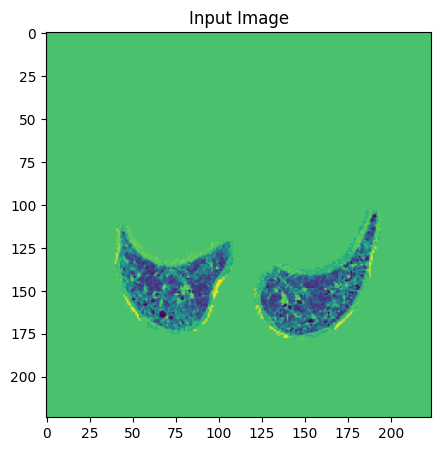

Training: 100%|██████████| 40/40 [11:03<00:00, 16.58s/it]



📊 Risk Statistics:
Slice risks  - Mean: 0.044, Std: 1.520, Range: [-2.908, 2.906]
Patient risks - Mean: 0.036, Std: 1.500, Range: [-2.873, 2.904]


Evaluating: 100%|██████████| 9/9 [02:04<00:00, 13.88s/it]


Train Loss: 3.0339
Val C-index: 0.6169
✅ Checkpoint saved at /content/drive/MyDrive/checkpoints_clipped/checkpoint_epoch_1.pth
✅ Saved best model (C-index: 0.6169)

Epoch 2/30


Training:   0%|          | 0/40 [00:00<?, ?it/s]

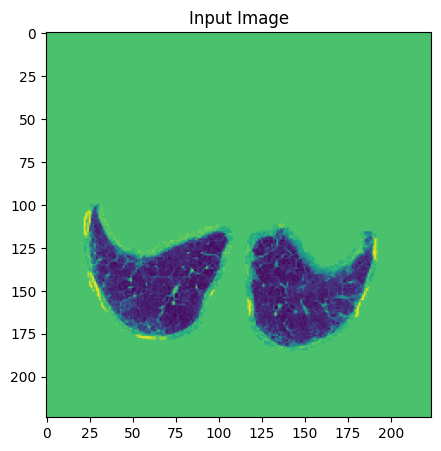

Training: 100%|██████████| 40/40 [11:25<00:00, 17.14s/it]



📊 Risk Statistics:
Slice risks  - Mean: 0.093, Std: 1.738, Range: [-2.971, 2.969]
Patient risks - Mean: 0.116, Std: 1.710, Range: [-2.971, 2.969]


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load data -> already have train_df,val_df,test_df
train_dataset = SliceLevelDataset(train_df, root_path=root_path)
val_dataset = SliceLevelDataset(val_df, root_path=root_path)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=patient_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=patient_collate)

# Model
model = SliceLevelCNN(backbone_name='efficientnet_b0', pretrained=True).to(device)
print(f"✅ Model initialized")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

scaler = torch.cuda.amp.GradScaler()
best_c_index = 0.0
num_epochs = 30
checkpoint_dir = "/content/drive/MyDrive/checkpoints_clipped"  # Directory for saving checkpoints

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Prepara il tracciamento delle metriche
train_losses = []
val_c_indexes = []

# Optionally, load checkpoint
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_epoch_9.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only = False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_c_index = checkpoint['c_index']
    start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    print(f"✅ Loaded checkpoint from epoch {start_epoch - 1}, C-index: {best_c_index:.4f}")

for epoch in range(start_epoch, num_epochs):

    torch.cuda.empty_cache()
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")

    # Train
    train_loss, scaler = train_epoch(model, train_loader, optimizer, device, scaler)
    train_losses.append(train_loss)

    # Validate
    val_c_index, val_risks, val_times, val_events = evaluate_slice_level(model, val_loader, device)
    val_c_indexes.append(val_c_index)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val C-index: {val_c_index:.4f}")

    # Scheduler step
    scheduler.step(val_c_index)

    # Save the model checkpoint after each epoch
    checkpoint_epoch_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'c_index': val_c_index,
    }, checkpoint_epoch_path)
    print(f"✅ Checkpoint saved at {checkpoint_epoch_path}")

    # Save the best model
    if val_c_index > best_c_index:
        best_c_index = val_c_index
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'c_index': val_c_index,
        }, os.path.join(checkpoint_dir, "best_slice_level_model.pth"))
        print(f"✅ Saved best model (C-index: {val_c_index:.4f})")

print(f"\n🎉 Training completed!")
print(f"   Best C-index: {best_c_index:.4f}")

# Traccia la perdita e il C-index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_c_indexes, label="Validation C-index")
plt.xlabel("Epoch")
plt.ylabel("C-index")
plt.title("Validation C-index per Epoch")

plt.tight_layout()
plt.show()
